In [63]:
import pandas as pd
from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [64]:
train = pd.read_csv('train.csv')
train = train.fillna('')

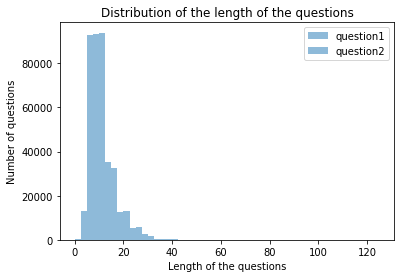

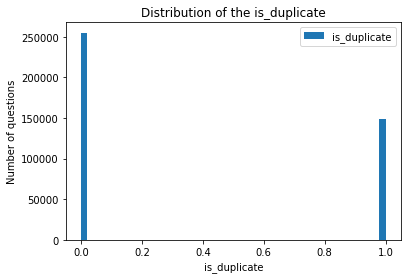

In [65]:
plt.hist(train['question1'].apply(lambda x: len(x.split())), bins=50, alpha=0.5, label='question1')
plt.title('Distribution of the length of the questions')
plt.xlabel('Length of the questions')
plt.ylabel('Number of questions')
plt.legend(['question1', 'question2'])
plt.show()

plt.hist(train['is_duplicate'], bins=50)
plt.title('Distribution of the is_duplicate')
plt.xlabel('is_duplicate')
plt.ylabel('Number of questions')
plt.legend(['is_duplicate'])
plt.show()

In [66]:
bias = train['is_duplicate'].sum() / train['is_duplicate'].count()
print('Bias = ', bias)
variance = train['is_duplicate'].var()
print('variance = ', variance)

Bias =  0.369197853026293
variance =  0.23289137439736537


In [67]:
train = train[:60000]
train, test, val = np.split(train.sample(frac=1), [int(.7*len(train)), int(.9*len(train))])
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
27347,27347,50815,50816,Should Naruto die?,How many and which characters die in Naruto?,0
45766,45766,56853,81959,Can I drink green tea at night?,Is it fine to drink green tea 2 hours after di...,0
14580,14580,27909,27910,Which is better modern education system or anc...,How can you argue that ancient Indian educatio...,0
28862,28862,53472,53473,Why do men have this need to boast to a potent...,"Why do many gay men marry women and have kids,...",0
5531,5531,10875,10876,How do I get admission in government schools o...,How can I get admissions in a good school in 1...,0


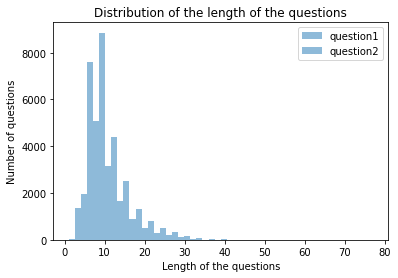

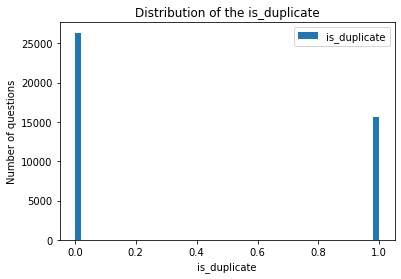

In [68]:
plt.hist(train['question1'].apply(lambda x: len(x.split())), bins=50, alpha=0.5, label='question1')
plt.title('Distribution of the length of the questions')
plt.xlabel('Length of the questions')
plt.ylabel('Number of questions')
plt.legend(['question1', 'question2'])
plt.show()

plt.hist(train['is_duplicate'], bins=50)
plt.title('Distribution of the is_duplicate')
plt.xlabel('is_duplicate')
plt.ylabel('Number of questions')
plt.legend(['is_duplicate'])
plt.show()

In [69]:
bias = train['is_duplicate'].sum() / train['is_duplicate'].count()
print('Bias = ', bias)
variance = train['is_duplicate'].var()
print('variance = ', variance)

Bias =  0.372952380952381
variance =  0.23386447069601438


In [70]:
def Vocab(str):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False, split=' ')
    tokenizer.fit_on_texts(str)
    return tokenizer

def SeqExt(str, tokenizer, seq_maxlen):
    str_seq = tokenizer.texts_to_sequences(str)
    arr = tf.keras.preprocessing.sequence.pad_sequences(str_seq, maxlen=seq_maxlen)
    arr = np.array(arr)
    return arr

In [71]:
str = train['question1'].tolist()
str = str + train['question2'].tolist()
str = str + test['question1'].tolist()
str = str + test['question2'].tolist()
str = str + val['question1'].tolist()
str = str + val['question2'].tolist()
tokenizer = Vocab(str)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

x_train1 = SeqExt(train['question1'], tokenizer, 128)
x_train2 = SeqExt(train['question2'], tokenizer, 128)
y_train = tf.keras.utils.to_categorical(train['is_duplicate'])

x_test1 = SeqExt(test['question1'], tokenizer, 128)
x_test2 = SeqExt(test['question2'], tokenizer, 128)
y_test = tf.keras.utils.to_categorical(test['is_duplicate'])

x_val1 = SeqExt(val['question1'], tokenizer, 128)
x_val2 = SeqExt(val['question2'], tokenizer, 128)
y_val = tf.keras.utils.to_categorical(val['is_duplicate'])

46728


In [72]:
def Glove():
    embedding_vectors = {}
    with open('glove.840B.300d.txt') as file:
        for line in tqdm(file):
            values = line.split(' ')
            coefs = np.asarray(values[1:], dtype='float32')
            word = values[0]
            embedding_vectors[word] = coefs
    return embedding_vectors

In [73]:
embedding_vectors = Glove()
print(len(embedding_vectors))

2196018it [01:03, 34539.74it/s]


2196017


In [74]:
def EmbedMat(embedding_vectors, word2idx):    
    embedding_matrix = np.zeros((len(word2idx)+1, 300))
    for word, i in tqdm(word2idx.items()):
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [75]:
embedmat = EmbedMat(embedding_vectors, tokenizer.word_index)
print(embedmat.shape)

100%|██████████| 46727/46727 [00:00<00:00, 193866.54it/s]

(46728, 300)


In [76]:
i1 = tf.keras.Input(shape=(x_train1.shape[1],))
i2 = tf.keras.Input(shape=(x_train2.shape[1],))

inner1= tf.keras.layers.Embedding(input_dim=embedmat.shape[0], output_dim=embedmat.shape[1], input_length=128, 
                                  weights=[embedmat], trainable=False)(i1)
inner2= tf.keras.layers.Embedding(input_dim=embedmat.shape[0], output_dim=embedmat.shape[1], input_length=128,
                                  weights=[embedmat], trainable=False)(i2)
inner = tf.keras.layers.concatenate([inner1+inner2, inner1-inner2, tf.math.multiply(inner1, inner2)], axis=-1)
out, h, c = tf.keras.layers.LSTM(150, return_sequences=False, dropout=0.2, return_state=True)(inner)
output = tf.keras.layers.Dense(2, activation='softmax')(c)

model = tf.keras.Model(inputs = [i1, i2], outputs = output)

In [77]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.009), loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 128, 300)     14018400    ['input_11[0][0]']               
                                                                                                  
 embedding_10 (Embedding)       (None, 128, 300)     14018400    ['input_12[0][0]']               
                                                                                            

In [78]:
checkpoint_filepath  = 'weights.best.{epoch:01d}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                verbose = 1, 
                                                                monitor = 'val_loss',
                                                                save_best_only = False)
history = model.fit((x_train1, x_train2), y_train,
                    batch_size = 8,
                    validation_data = ((x_val1, x_val2), y_val),
                    validation_batch_size = 4,
                    epochs=4,
                    callbacks=[model_checkpoint_callback], 
                    verbose=1)

Epoch 1/4
5250/5250 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.6956
Epoch 1: saving model to weights.best.1.hdf5
5250/5250 [==============================] - 472s 90ms/step - loss: 0.5886 - accuracy: 0.6956 - val_loss: 0.5721 - val_accuracy: 0.7122
Epoch 2/4
5250/5250 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7234
Epoch 2: saving model to weights.best.2.hdf5
5250/5250 [==============================] - 464s 88ms/step - loss: 0.5547 - accuracy: 0.7234 - val_loss: 0.5677 - val_accuracy: 0.7092
Epoch 3/4
5250/5250 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.7315
Epoch 3: saving model to weights.best.3.hdf5
5250/5250 [==============================] - 468s 89ms/step - loss: 0.5344 - accuracy: 0.7315 - val_loss: 0.5463 - val_accuracy: 0.7307
Epoch 4/4
5250/5250 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.7370
Epoch 4: saving model to weights.best.4.hdf5
5250/5250 [=============

In [79]:
loss, accuracy = model.evaluate((x_test1, x_test2), y_test, batch_size=4, verbose=1)
print('Loss :', loss), print('Accuracy :', accuracy)

3000/3000 [==============================] - 65s 21ms/step - loss: 0.5600 - accuracy: 0.7163
Loss : 0.5599597692489624
Accuracy : 0.7163333296775818


(None, None)

In [80]:
pred = model.predict((x_test1, x_test2))
print('f1_score on test dataset is', f1_score(np.argmax(pred, axis=1), np.argmax(y_test, axis=1)))

375/375 [==============================] - 16s 41ms/step
f1_score on test dataset is 0.6291130965351929
